In [1]:
import os, sys
import numpy as np
import scipy.io as sio
from skimage import io
import skimage.transform
import matplotlib.pyplot as plt

sys.path.append('..')
import face3d
import trimesh
from face3d import mesh
from face3d.morphable_model import MorphabelModel

In [2]:
def create_spherical_coords_grid(resolution=512):
    theta = np.linspace(0, np.pi, resolution)  # 0 to π
    phi = np.linspace(0, 2 * np.pi, resolution)  # 0 to 2π
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    return theta_grid, phi_grid

def calculate_radius(vertices, center_point):
    return np.linalg.norm(vertices - center_point, axis=1)


In [3]:
image_path = 'Data/300W_LP/IBUG/IBUG_image_003_1_0.jpg'
mat_path = 'Data/300W_LP/IBUG/IBUG_image_003_1_0.mat'
save_folder = 'single_results/posmap_300WLP_4995'

In [97]:
# uv_coords = face3d.morphable_model.load.load_uv_coords('Data/BFM/Out/BFM_UV.mat')
# uv_coords = process_uv(uv_coords, uv_h, uv_w)
bfm = MorphabelModel('Data/BFM/Out/BFM.mat')

In [98]:
info = sio.loadmat(mat_path)
shape_para = info['Shape_Para'].astype(np.float32)
exp_para = info['Exp_Para'].astype(np.float32)
vertices = bfm.generate_vertices(shape_para, exp_para)

In [99]:
faces = bfm.full_triangles

# Create a trimesh mesh object
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

if not mesh.is_volume:
    print("Warning: The mesh is not a valid volume. This might affect proximity queries.")

In [100]:
mesh.show()

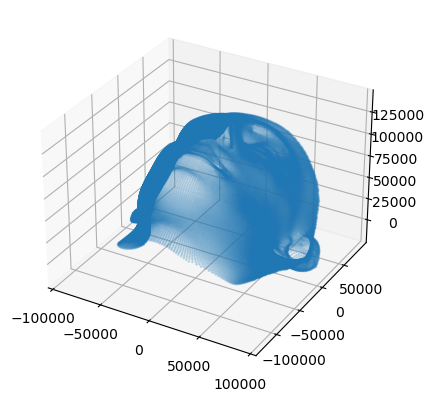

In [102]:
point_cloud = trimesh.points.PointCloud(vertices)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(vertices[:, 0], vertices[:, 1], faces, vertices[:, 2], color='pink', alpha=0.3)
ax.scatter(point_cloud.vertices[:, 0], point_cloud.vertices[:, 1], point_cloud.vertices[:, 2], s=1, alpha=0.2)
plt.show()

In [402]:
# Replace with the path to your BFM model file
bfm = MorphabelModel('Data/BFM/Out/BFM.mat')

# Example parameters (replace with actual data or parameters from your model)
shape_para = np.random.rand(bfm.n_shape_para, 1)  # Example shape parameters
exp_para = np.random.rand(bfm.n_exp_para, 1)      # Example expression parameters

# Generate vertices of the 3D face model
vertices = bfm.generate_vertices(shape_para, exp_para)

# Find the geometric center of the model
face_center = np.mean(vertices, axis=0)

In [403]:
def cartesian_to_spherical(coords, center):
    x, y, z = coords - center
    radius = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arctan2(np.sqrt(x**2 + y**2), z)  # Inclination
    phi = np.arctan2(y, x)                      # Azimuth
    return phi, theta, radius

# Convert each vertex to spherical coordinates
spherical_coords = np.array([cartesian_to_spherical(v, face_center) for v in vertices])


In [417]:
# Define the resolution of your 2D map
res_phi, res_theta = 1024, 1024  # Adjust as needed
radius_map = np.zeros((res_theta, res_phi))

# Populate the radius map
for phi, theta, radius in spherical_coords:
    # Convert spherical coordinates to 2D map indices
    i = int(((phi + np.pi) / (2 * np.pi)) * (res_phi - 1))
    j = int((theta / np.pi) * (res_theta - 1))

    radius_map[j, i] = radius

# Normalize the radius map for visualization
radius_map_normalized = (radius_map - np.min(radius_map)) / (np.max(radius_map) - np.min(radius_map))


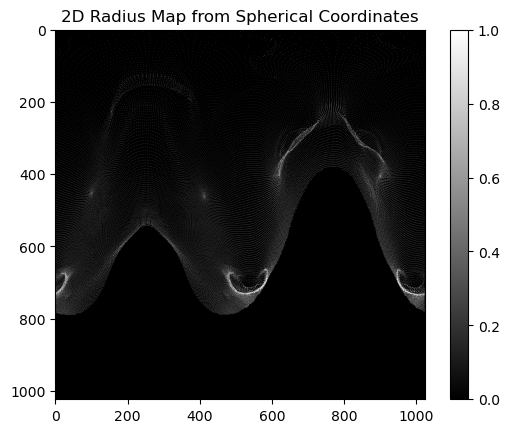

In [418]:
plt.imshow(radius_map_normalized, cmap='gray')
plt.colorbar()
plt.title("2D Radius Map from Spherical Coordinates")
plt.show()


In [419]:
def spherical_to_cartesian(phi, theta, radius):
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return np.array([x, y, z])

# Initialize an array to hold the reconstructed 3D points
reconstructed_vertices = []

# Iterate through the 2D radius map
for i in range(res_phi):
    for j in range(res_theta):
        # Convert the 2D indices back to spherical coordinates (phi, theta)
        phi = (i / (res_phi - 1)) * 2 * np.pi - np.pi
        theta = (j / (res_theta - 1)) * np.pi

        # Retrieve the radius from the map
        radius = radius_map[j, i]

        # Convert back to Cartesian coordinates
        if radius > 0:  # Skip points with zero radius
            vertex = spherical_to_cartesian(phi, theta, radius)
            reconstructed_vertices.append(vertex)

reconstructed_vertices = np.array(reconstructed_vertices)

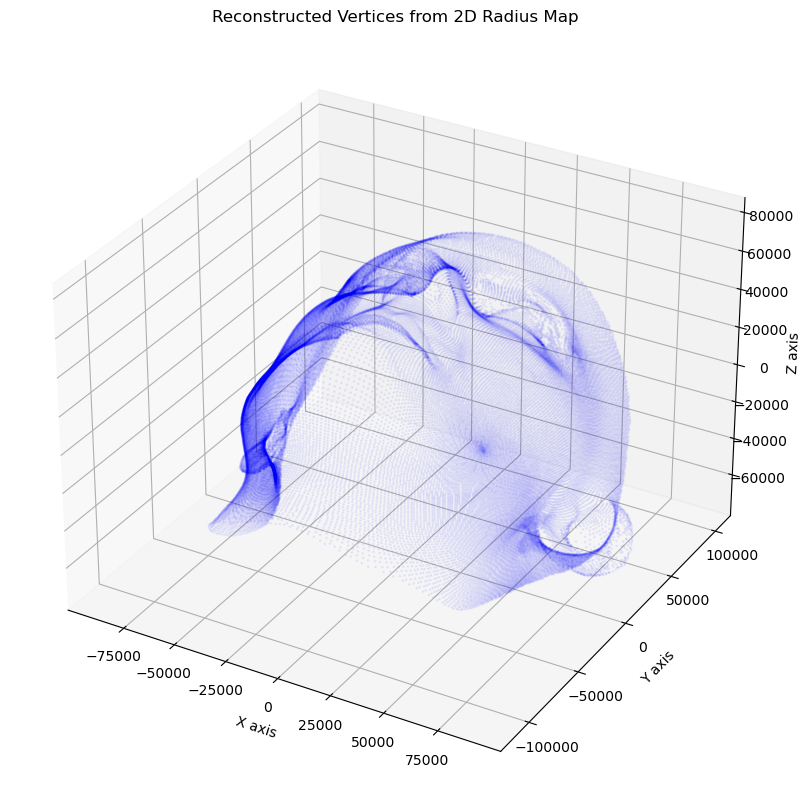

In [420]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the reconstructed vertices
ax.scatter(reconstructed_vertices[:, 0], reconstructed_vertices[:, 1], reconstructed_vertices[:, 2], color="blue", s=1, alpha=0.05)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.title("Reconstructed Vertices from 2D Radius Map")
plt.show()

In [4]:
# Replace with the path to your BFM model file
bfm = MorphabelModel('Data/BFM/Out/BFM.mat')

# Example parameters (replace with actual data or parameters from your model)
shape_para = np.random.rand(bfm.n_shape_para, 1)  # Example shape parameters
exp_para = np.random.rand(bfm.n_exp_para, 1)      # Example expression parameters

# Generate vertices of the 3D face model
vertices = bfm.generate_vertices(shape_para, exp_para)

# Find the geometric center of the model
face_center = np.mean(vertices, axis=0)

z_offset = -15000

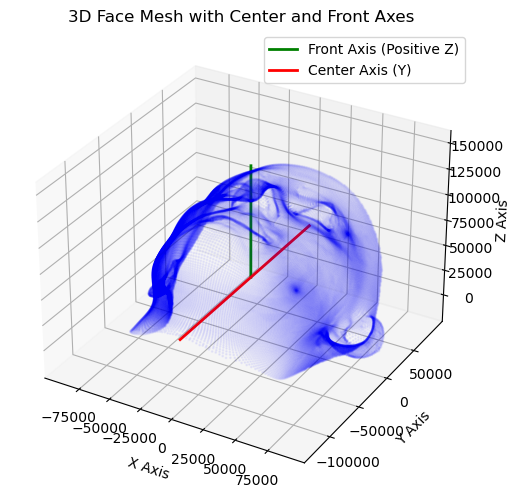

In [81]:
x, y, z = vertices[:,0], vertices[:,1], vertices[:,2]
center_x, center_y, center_z = face_center[0], face_center[1], face_center[2] + z_offset

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, color='blue', s=1, alpha=0.05)

# Plot the front-facing axis (positive z-axis)
z_front_min, z_front_max = center_z, 150000
ax.plot([center_x, center_x], [center_y, center_y], [z_front_min, z_front_max], color='green', linewidth=2, label='Front Axis (Positive Z)')

# Plot the center axis
ax.plot([center_x, center_x], [np.min(y), np.max(y)], [center_z, center_z], color='red', linewidth=2, label='Center Axis (Y)')

# Set labels and title
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('3D Face Mesh with Center and Front Axes')
ax.legend()

plt.show()

In [31]:
def get_vertex_position_on_radial_map(vertex, face_center, z_offset, res_phi, res_y, min_y, max_y):
    r, phi, y = cartesian_to_cylindrical_vertical_axis(vertex, face_center, z_offset)

    leftmost_phi = -np.pi/2
    rightmost_phi = np.pi/2
    if leftmost_phi <= phi <= rightmost_phi:
        phi_normalized = (phi - leftmost_phi) / (rightmost_phi - leftmost_phi)
        y_normalized = (y - min_y) / (max_y - min_y)

        i = int(phi_normalized * (res_phi - 1))
        j = res_y - 1 - int(y_normalized * (res_y - 1))

        return r, i, j
    else:
        return None

def map_position_to_vertex(i, j, r, face_center, z_offset, res_phi, res_y, min_y, max_y):
    # Denormalize the map coordinates
    phi_normalized = i / (res_phi - 1)
    y_normalized = 1 - j / (res_y - 1)

    # Convert normalized coordinates back to original phi and y
    phi = phi_normalized * (np.pi) - np.pi / 2
    y = y_normalized * (max_y - min_y) + min_y

    # Convert from cylindrical back to Cartesian coordinates
    x = np.cos(phi) * r + face_center[0]
    z = np.sin(phi) * r + face_center[2] + z_offset
    return x, y, z

def cartesian_to_cylindrical_vertical_axis(vertex, face_center, z_offset):
    x, z, y = vertex[0] - face_center[0], vertex[2] - (face_center[2] + z_offset), vertex[1]
    r = np.sqrt(x**2 + z**2)
    phi = np.arctan2(x, z)
    return r, phi, y

In [57]:
# initialize the radial map
res_phi, res_y = 512, 512  # Resolution of the cylindrical map, adjust as needed!
radial_map = np.zeros((res_y, res_phi))

In [64]:
# Precompute min and max y values for normalization
min_y, max_y = np.min(vertices[:,1]), np.max(vertices[:,1])

# Initialize the radial map
radial_map = np.zeros((res_y, res_phi))

# Populate the radial map
for vertex in vertices:
    result = get_vertex_position_on_radial_map(vertex, face_center, z_offset, res_phi, res_y, min_y, max_y)
    
    if result is not None:
        r, i, j = result
        radial_map[j, i] = r

# Normalize the radial map for visualization
radial_map_normalized = (radial_map - np.min(radial_map)) / (np.max(radial_map) - np.min(radial_map))

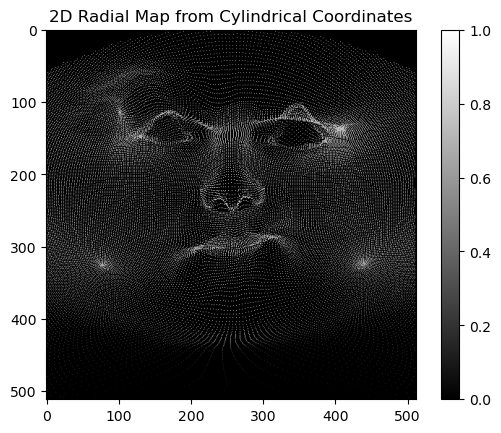

In [65]:
plt.imshow(radial_map_normalized, cmap='gray')
plt.colorbar()
plt.title("2D Radial Map from Cylindrical Coordinates")
plt.show()

In [69]:
def find_bounding_box_and_vertices_of_triangle(triangle, face_center, z_offset, res_phi, res_y, min_y, max_y):
    min_i = res_phi - 1
    max_i = 0
    min_j = res_y - 1
    max_j = 0
    depths = []
    map_vertices = []

    for vertex in triangle:
        result = get_vertex_position_on_radial_map(vertex, face_center, z_offset, res_phi, res_y, min_y, max_y)
        
        if result is not None:
            r, i, j = result
            min_i = min(min_i, i)
            max_i = max(max_i, i)
            min_j = min(min_j, j)
            max_j = max(max_j, j)
            depths.append(r)
            map_vertices.append((i, j))

    # Check if there are exactly three valid vertices
    if len(depths) == 3 and len(map_vertices) == 3 and min_i <= max_i and min_j <= max_j:
        bounding_box = (min_i, max_i, min_j, max_j)
        return bounding_box, depths, map_vertices
    else:
        return None, None, None

In [66]:
def barycentric_coordinates(triangle_vertices, point):
    A, B, C = triangle_vertices
    v0 = B - A
    v1 = C - A
    v2 = point - A
    d00 = np.dot(v0, v0)
    d01 = np.dot(v0, v1)
    d11 = np.dot(v1, v1)
    d20 = np.dot(v2, v0)
    d21 = np.dot(v2, v1)
    denom = d00 * d11 - d01 * d01
    v = (d11 * d20 - d01 * d21) / denom
    w = (d00 * d21 - d01 * d20) / denom
    u = 1.0 - v - w
    return u, v, w

def interpolate_depth_within_bounding_box(map_vertices, triangle_depths, bounding_box, res_phi, res_y):
    # Unpack the bounding box
    min_i, max_i, min_j, max_j = bounding_box

    # Create an array to hold the interpolated depths, sized to fit the bounding box
    bbox_height = max_j - min_j + 1
    bbox_width = max_i - min_i + 1
    interpolated_depths = np.zeros((bbox_height, bbox_width))

    tri_vertices = np.array([[v[0], v[1]] for v in map_vertices])

    for i in range(min_i, max_i + 1):
        for j in range(min_j, max_j + 1):
            # Compute Barycentric coordinates in the map coordinate system
            u, v, w = barycentric_coordinates(tri_vertices, (i, j))

            # Check if the point is inside the triangle
            if 0 <= u <= 1 and 0 <= v <= 1 and 0 <= w <= 1:
                # Interpolate the depth value
                interpolated_depth = triangle_depths[0] * u + triangle_depths[1] * v + triangle_depths[2] * w
                interpolated_depths[j - min_j, i - min_i] = interpolated_depth

    return interpolated_depths




In [12]:
faces = bfm.full_triangles

In [70]:
interpolated_map_normalized = np.zeros((res_y, res_phi))
for triangle_indices in faces:
    triangle_vertices = [vertices[index] for index in triangle_indices]
    bbox, triangle_depths, triangle_map_vertices = find_bounding_box_and_vertices_of_triangle(triangle_vertices, face_center, z_offset, res_phi, res_y, min_y, max_y)
    if bbox is None:
        continue

    interpolated_map = interpolate_depth_within_bounding_box(triangle_map_vertices, triangle_depths, bbox, res_phi, res_y)
    
    min_i, max_i, min_j, max_j = bbox
    for i in range(min_i, max_i + 1):
            for j in range(min_j, max_j + 1):
                depth = interpolated_map[j - min_j, i - min_i]
                if depth > interpolated_map_normalized[j, i]:
                    interpolated_map_normalized[j, i] = depth

C:\Users\chenb\AppData\Local\Temp\ipykernel_23828\210135292.py:12: RuntimeWarning: invalid value encountered in scalar divide
  v = (d11 * d20 - d01 * d21) / denom
C:\Users\chenb\AppData\Local\Temp\ipykernel_23828\210135292.py:13: RuntimeWarning: invalid value encountered in scalar divide
  w = (d00 * d21 - d01 * d20) / denom


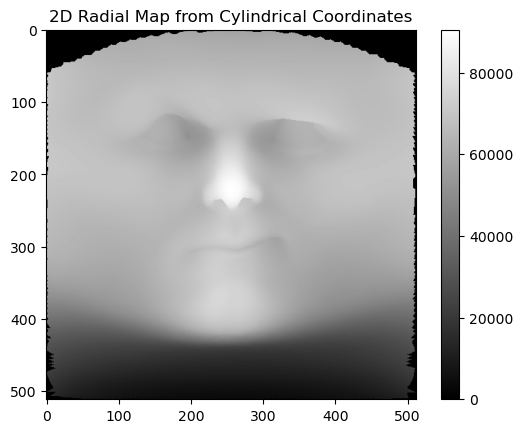

In [71]:
plt.imshow(interpolated_map_normalized, cmap='gray')
plt.colorbar()
plt.title("2D Radial Map from Cylindrical Coordinates")
plt.show()

In [76]:
# Initialize an array to hold the reconstructed vertices
reconstructed_vertices = []

# Iterate over the 2D map
for j in range(res_y):
    for i in range(res_phi):
        # Retrieve the radius value from the interpolated map
        r = radial_map_normalized[j, i]

        # Skip points where the radius is zero
        if r == 0:
            continue

        # Reverse the normalization of the azimuthal angle and y-coordinate
        phi = (i / (res_phi - 1)) * np.pi - np.pi / 2
        y = np.max(vertices[:,1]) - (j / (res_y - 1)) * (np.max(vertices[:,1]) - np.min(vertices[:,1]))

        # Convert back to Cartesian coordinates
        x = r * np.sin(phi) + center_x
        z = r * np.cos(phi) + center_z - z_offset
        reconstructed_vertices.append([x, y, z])

reconstructed_vertices = np.array(reconstructed_vertices)


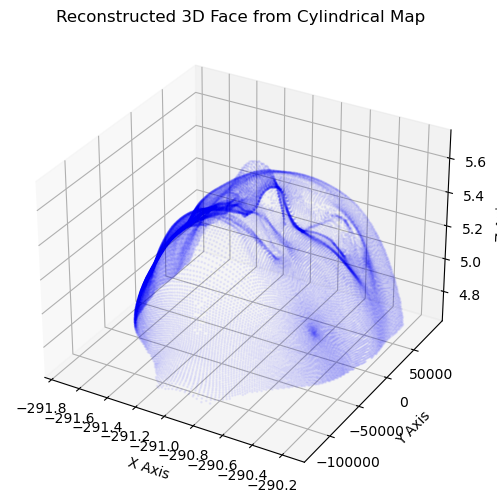

In [77]:
# Plotting the reconstructed vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(reconstructed_vertices[:,0], reconstructed_vertices[:,1], reconstructed_vertices[:,2], color='blue', s=1, alpha=0.05)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Reconstructed 3D Face from Cylindrical Map')

plt.show()


In [78]:
# Initialize an array to hold the reconstructed vertices
reconstructed_vertices_interpolated = []

# Iterate over the 2D map
for j in range(res_y):
    for i in range(res_phi):
        # Retrieve the radius value from the interpolated map
        r = interpolated_map_normalized[j, i]

        # Skip points where the radius is zero
        if r == 0:
            continue

        # Reverse the normalization of the azimuthal angle and y-coordinate
        phi = (i / (res_phi - 1)) * np.pi - np.pi / 2
        y = np.max(vertices[:,1]) - (j / (res_y - 1)) * (np.max(vertices[:,1]) - np.min(vertices[:,1]))

        # Convert back to Cartesian coordinates
        x = r * np.sin(phi) + center_x
        z = r * np.cos(phi) + center_z - z_offset
        reconstructed_vertices_interpolated.append([x, y, z])

reconstructed_vertices_interpolated = np.array(reconstructed_vertices_interpolated)

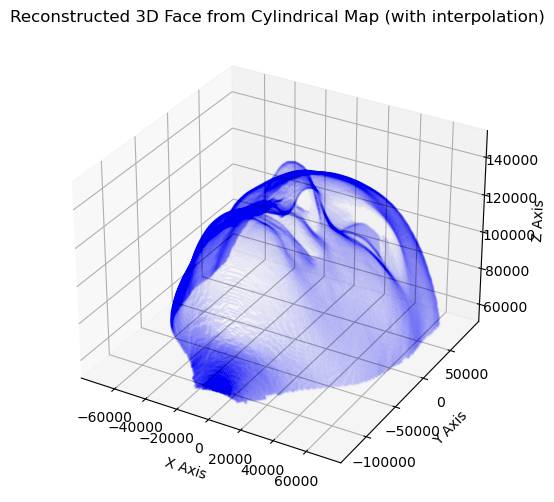

In [79]:
# Plotting the reconstructed vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(reconstructed_vertices_interpolated[:,0], reconstructed_vertices_interpolated[:,1], reconstructed_vertices_interpolated[:,2], color='blue', s=1, alpha=0.01)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Reconstructed 3D Face from Cylindrical Map (with interpolation)')

plt.show()

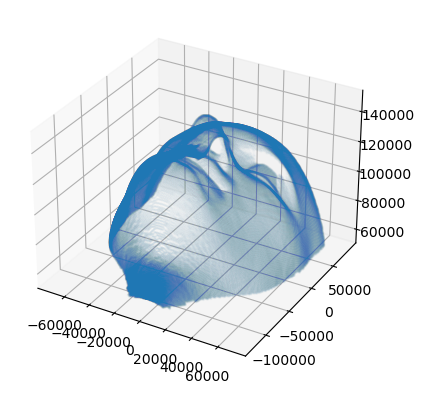

In [105]:
point_cloud = trimesh.points.PointCloud(reconstructed_vertices_interpolated)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(vertices[:, 0], vertices[:, 1], faces, vertices[:, 2], color='pink', alpha=0.3)
ax.scatter(point_cloud.vertices[:, 0], point_cloud.vertices[:, 1], point_cloud.vertices[:, 2], s=1, alpha=0.01)
plt.show()